In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from mp_api.client import MPRester

/Users/bcrouch/anaconda3/envs/pymatenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Reassemble data from MP and SuperCon sources

In [52]:
# "prop" is 1 for superconductors, 0 for non-superconductors

files = pd.Series(os.listdir("../../Fall 2023/MSE 331/Final Project/root_dir"))
mp_files = files[files.str.match(r"^mp-\d+.cif$")]

mp_id_prop = mp_files.str.extract(r"([mp\-0-9]+).cif")
mp_id_prop["prop"] = 0
mp_id_prop = mp_id_prop.rename(columns={0:"ID"})
mp_id_prop["mpid"] = mp_id_prop["ID"]

supercon = pd.read_csv("../../Fall 2023/MSE 331/Final Project/3DSC_MP.csv", header=1)
supercon["mpid"] = supercon["cif"].str.extract(r".*(mp-\d+).*")
supercon["ID"] = supercon["cif"].str.extract(r"data/final/MP/cifs/([^/]+).cif")

mp_id_prop = mp_id_prop[~mp_id_prop["ID"].isin(supercon["mpid"])] # Remove superconductors from MP data

supercon = supercon[supercon["synth_doped"]==False]
supercon_id_prop = supercon[["ID", "mpid"]]
supercon_id_prop["prop"] = 1

id_prop = pd.concat([mp_id_prop, supercon_id_prop])

/var/folders/bv/cvzjylhd5711t9s1y4r255_00000gn/T/ipykernel_1716/4057762272.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supercon_id_prop["prop"] = 1


Link MPIDs with band structure data available – only 70158 out of original 152908

In [53]:
has_bs = pd.read_csv("mpid_with_bs", header=None).rename(columns={0:"mpid"})

In [54]:
id_prop = id_prop[id_prop["mpid"].isin(has_bs["mpid"])]

Because flatness calculation is still running, MPIDs that have not yet been evaluated are assigned flatness = 0. MPIDs with corrupted band structure data are assigned flatness = NaN

In [216]:
flatness_data = pd.read_csv("flatness_scores").rename(columns={"Unnamed: 0":"mpid"})
flatness_data = flatness_data[(~np.any(flatness_data[['1_ev', '0.75_ev', '0.5_ev', '0.25_ev', '0.1_ev']]==0, axis=1))&(~np.any(flatness_data.isna(), axis=1))]
flatness_data = id_prop.merge(flatness_data, on="mpid")

In [168]:
# Roughly 5% superconductors
flatness_data["prop"].value_counts()/len(flatness_data)

0    0.957739
1    0.042261
Name: prop, dtype: float64

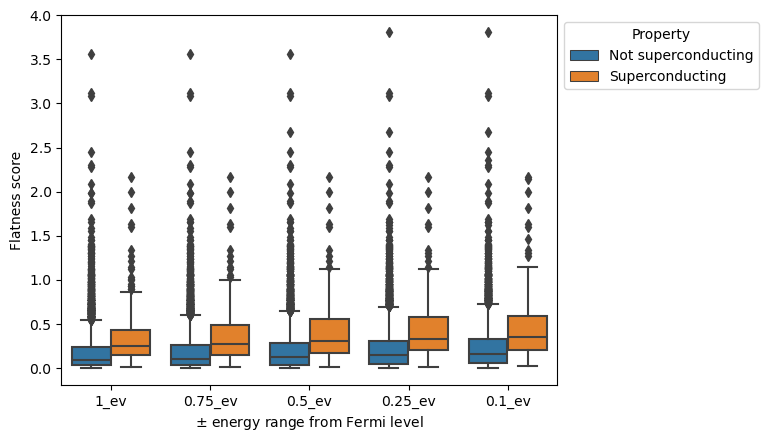

In [169]:
sns.boxplot(flatness_data.melt(["ID", "mpid", "prop"]).replace({0:"Not superconducting", 1:"Superconducting"}), x="variable", y="value", hue="prop")
plt.xlabel(r"$\pm$ energy range from Fermi level")
plt.ylabel("Flatness score")
plt.legend(title="Property", bbox_to_anchor=(1, 1));

Segment by crystal structure

In [196]:
with MPRester("mm94cVv26LicCVGIuLbUKBdh3Gehfv0l") as mpr:
    symmetries = mpr.materials.search(fields=["symmetry", "material_id", "band_gap"])

Retrieving MaterialsDoc documents: 100%|█| 153235/153235 [01:40<00:00, 1526.77it


In [200]:
with MPRester("mm94cVv26LicCVGIuLbUKBdh3Gehfv0l") as mpr:
    band_gaps = mpr.summary.search(fields=["band_gap", "material_id"])

/var/folders/bv/cvzjylhd5711t9s1y4r255_00000gn/T/ipykernel_1716/3326165761.py:2: DeprecationWarning: Accessing summary data through MPRester.summary is deprecated. Please use MPRester.materials.summary instead.
  band_gaps = mpr.summary.search(fields=["band_gap", "material_id"])
Retrieving SummaryDoc documents: 100%|█| 153235/153235 [00:47<00:00, 3259.81it/s


In [121]:
systems = [str(struct.symmetry.crystal_system) for struct in symmetries]
systems_mpid = [str(struct.material_id) for struct in symmetries]

In [202]:
gaps = [str(struct.band_gap) for struct in band_gaps]
gaps_mpid = [str(struct.material_id) for struct in band_gaps]

In [134]:
crystal_systems = pd.DataFrame(np.array([systems, systems_mpid]).T).rename(columns={0:"system", 1:"mpid"})

In [217]:
band_gap_df = pd.DataFrame(np.array([gaps, gaps_mpid]).T).rename(columns={0:"band_gap", 1:"mpid"})
band_gap_df["band_gap"] = band_gap_df["band_gap"].replace({"None":np.nan}).astype(float)

In [218]:
flatness_data = flatness_data.merge(crystal_systems, on="mpid").merge(band_gap_df, on="mpid")

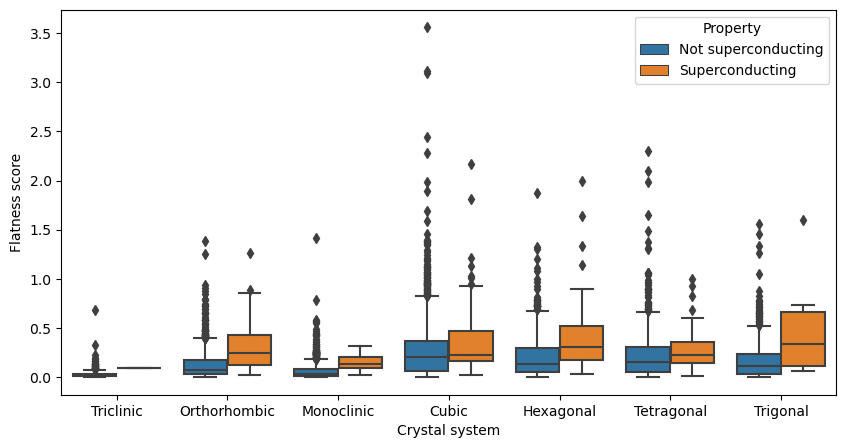

In [172]:
plt.figure(figsize=(10, 5))
sns.boxplot(flatness_data[["1_ev", "prop", "system"]].melt(["1_ev", "prop"]).replace({0:"Not superconducting", 1:"Superconducting"}), x="value", y="1_ev", hue="prop")
plt.xlabel("Crystal system")
plt.ylabel("Flatness score")
plt.legend(title="Property");

In [238]:
flatness_data.groupby(["system", "prop"])[["mpid"]].count()

mpid
system       prop      
Cubic        0     1410
             1       86
Hexagonal    0      703
             1       66
Monoclinic   0     1068
             1       12
Orthorhombic 0     1412
             1       56
Tetragonal   0     1118
             1       63
Triclinic    0      427
             1        1
Trigonal     0      742
             1       10

For closer equivalence, try only considering non-superconductors with band gaps on the order of those in superconductors

In [228]:
# <0.1 eV band gap heuristic used in literature
near_metal = flatness_data[flatness_data["band_gap"]<0.1]

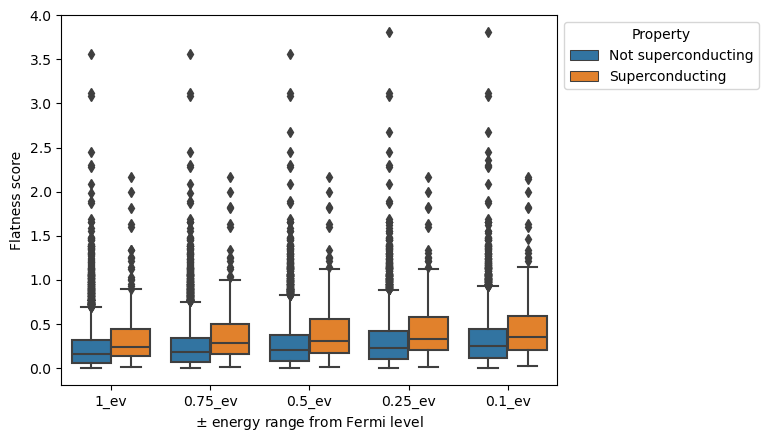

In [232]:
sns.boxplot(near_metal.drop(columns=["system", "band_gap"]).melt(["ID", "mpid", "prop"]).replace({0:"Not superconducting", 1:"Superconducting"}), x="variable", y="value", hue="prop")
plt.xlabel(r"$\pm$ energy range from Fermi level")
plt.ylabel("Flatness score")
plt.legend(title="Property", bbox_to_anchor=(1, 1));

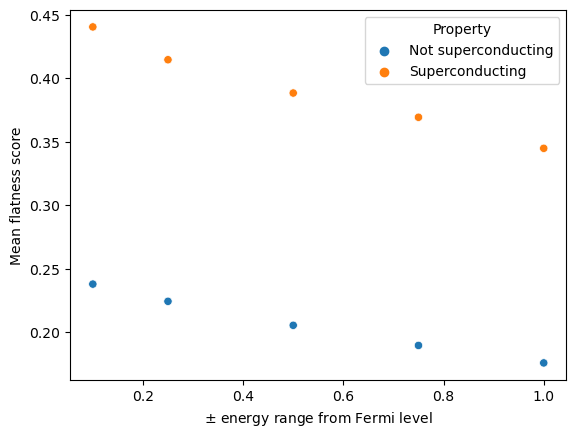

In [237]:
reg = flatness_data[["prop", "1_ev", "0.75_ev", "0.5_ev", "0.25_ev", "0.1_ev"]].groupby("prop").mean().T.reset_index().melt("index")
reg["energy_window"] = reg["index"].str.extract(r"([0-9.]+)_ev").astype(float)
reg["prop"] = reg["prop"].replace({0:"Not superconducting", 1:"Superconducting"})

sns.scatterplot(reg, x="energy_window", y="value", hue="prop")
plt.xlabel(r"$\pm$ energy range from Fermi level")
plt.ylabel("Mean flatness score")
plt.legend(title="Property");